# Predict Stock Price

1. Get historic stock price data
2. Extract price to predict
3. Normalize
4. Create Time Series
5. Build model
6. Fit model
7. Test and evaluate

In [1]:
from keras import backend as K
import os
from importlib import reload

def set_keras_backend(backend):
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend

set_keras_backend("cntk")

Using TensorFlow backend.
Using CNTK backend


ModuleNotFoundError: ignored

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.cross_validation import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
np.random.seed(7)

In [8]:
#load the dataset
msft_dataset = pd.read_csv('https://raw.githubusercontent.com/toufiqElahy/csv/master/BIG.csv')
msft_dataset.head()

,Unnamed: 0,Code,Ex,Date,Open,High,Low,Close,Adjusted_close,Volume,Prev_close,Change,Change_%
0,2980,BIG,US,2012-01-03,38.25,38.925,38.05,38.20,35.2884,969600.0,NaN,NaN,NaN
1,2983,BIG,US,2012-01-04,38.20,38.765,37.98,38.60,35.6579,1216600.0,NaN,NaN,NaN
2,2983,BIG,US,2012-01-05,38.44,38.730,37.65,38.70,35.7502,236894.0,NaN,NaN,NaN
3,2975,BIG,US,2012-01-06,38.59,38.620,38.06,38.16,35.2514,210920.0,NaN,NaN,NaN
4,2982,BIG,US,2012-01-09,38.08,38.450,37.65,38.18,35.2699,827600.0,NaN,NaN,NaN


In [9]:
msft_dataset.dtypes

Unnamed: 0          int64
Code               object
Ex                 object
Date               object
Open              float64
High              float64
Low               float64
Close             float64
Adjusted_close    float64
Volume            float64
Prev_close        float64
Change            float64
Change_%          float64
dtype: object

In [10]:
msft_dataset['Date'] = pd.to_datetime(msft_dataset['Date'])
msft_dataset['Close'] = pd.to_numeric(msft_dataset['Close'], downcast='float')

In [12]:
msft_dataset.set_index('Date',inplace=True)
msft_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1634 entries, 2012-01-03 to 2018-06-29
Data columns (total 12 columns):
Unnamed: 0        1634 non-null int64
Code              1634 non-null object
Ex                1634 non-null object
Open              1634 non-null float64
High              1634 non-null float64
Low               1634 non-null float64
Close             1634 non-null float32
Adjusted_close    1634 non-null float64
Volume            1634 non-null float64
Prev_close        0 non-null float64
Change            0 non-null float64
Change_%          0 non-null float64
dtypes: float32(1), float64(8), int64(1), object(2)
memory usage: 159.6+ KB


In [13]:
msft_dataset.sort_index(inplace=True)

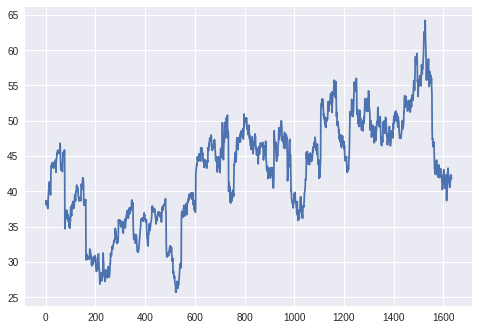

In [14]:
#extract just close prices as that is what we want to predict
msft_close = msft_dataset['Close']
msft_close = msft_close.values.reshape(len(msft_close), 1)
plt.plot(msft_close)
plt.show()

In [15]:
#normalize data
scaler = MinMaxScaler(feature_range=(0,1))

In [16]:
msft_close = scaler.fit_transform(msft_close)
msft_close

array([[0.32433134],
       [0.33471823],
       [0.33731496],
       ...,
       [0.42794073],
       [0.423007  ],
       [0.41729414]], dtype=float32)

In [17]:
#split data into train and test
train_size = int(len(msft_close)* 0.7)
test_size = len(msft_close) - train_size

msft_train, msft_test = msft_close[0:train_size, :], msft_close[train_size:len(msft_close), :]

print('Split data into train and test: ', len(msft_train), len(msft_test))

Split data into train and test:  1143 491


In [18]:
#need to now convert the data into time series looking back over a period of days...e.g. use last 7 days to predict price

def create_ts(ds, series):
    X, Y =[], []
    for i in range(len(ds)-series - 1):
        item = ds[i:(i+series), 0]
        X.append(item)
        Y.append(ds[i+series, 0])
    return np.array(X), np.array(Y)

series = 7

trainX, trainY = create_ts(msft_train, series)
testX, testY = create_ts(msft_test, series)


In [19]:
trainX

array([[0.32433134, 0.33471823, 0.33731496, ..., 0.323812  , 0.33367956,
        0.31680083],
       [0.33471823, 0.33731496, 0.3232926 , ..., 0.33367956, 0.31680083,
        0.31316543],
       [0.33731496, 0.3232926 , 0.323812  , ..., 0.31680083, 0.31316543,
        0.30823165],
       ...,
       [0.6302259 , 0.6330823 , 0.63775635, ..., 0.69696176, 0.70163584,
        0.6863152 ],
       [0.6330823 , 0.63775635, 0.65930915, ..., 0.70163584, 0.6863152 ,
        0.66580105],
       [0.63775635, 0.65930915, 0.69696176, ..., 0.6863152 , 0.66580105,
        0.6663203 ]], dtype=float32)

In [20]:
trainX[0]

array([0.32433134, 0.33471823, 0.33731496, 0.3232926 , 0.323812  ,
       0.33367956, 0.31680083], dtype=float32)

In [22]:
#reshape into  LSTM format - samples, steps, features
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [23]:
#build the model
model = Sequential()
model.add(LSTM(4, input_shape=(series, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
#fit the model
model.fit(trainX, trainY, epochs=100, batch_size=32)

Epoch 1/100
1135/1135 [==============================] - 2s 2ms/step - loss: 0.0695
Epoch 2/100
1135/1135 [==============================] - 1s 691us/step - loss: 0.0217
Epoch 3/100
1135/1135 [==============================] - 1s 682us/step - loss: 0.0102
Epoch 4/100
1135/1135 [==============================] - 1s 683us/step - loss: 0.0081
Epoch 5/100
1135/1135 [==============================] - 1s 692us/step - loss: 0.0065
Epoch 6/100
1135/1135 [==============================] - 1s 683us/step - loss: 0.0051
Epoch 7/100
1135/1135 [==============================] - 1s 689us/step - loss: 0.0038
Epoch 8/100
1135/1135 [==============================] - 1s 704us/step - loss: 0.0029
Epoch 9/100
1135/1135 [==============================] - 1s 703us/step - loss: 0.0023
Epoch 10/100
1135/1135 [==============================] - 1s 706us/step - loss: 0.0019
Epoch 11/100
1135/1135 [==============================] - 1s 707us/step - loss: 0.0018
Epoch 12/100
1135/1135 [==============================

1135/1135 [==============================] - 1s 684us/step - loss: 0.0017
Epoch 14/100
1135/1135 [==============================] - 1s 694us/step - loss: 0.0017
Epoch 15/100
1135/1135 [==============================] - 1s 673us/step - loss: 0.0017
Epoch 16/100
1135/1135 [==============================] - 1s 705us/step - loss: 0.0017
Epoch 17/100
1135/1135 [==============================] - 1s 692us/step - loss: 0.0017
Epoch 18/100
1135/1135 [==============================] - 1s 710us/step - loss: 0.0016
Epoch 19/100
1135/1135 [==============================] - 1s 709us/step - loss: 0.0016
Epoch 20/100
1135/1135 [==============================] - 1s 705us/step - loss: 0.0016
Epoch 21/100
1135/1135 [==============================] - 1s 688us/step - loss: 0.0016
Epoch 22/100
1135/1135 [==============================] - 1s 694us/step - loss: 0.0016
Epoch 23/100
1135/1135 [==============================] - 1s 681us/step - loss: 0.0016
Epoch 24/100
1135/1135 [==============================] 

1135/1135 [==============================] - 1s 673us/step - loss: 0.0016
Epoch 26/100
1135/1135 [==============================] - 1s 669us/step - loss: 0.0016
Epoch 27/100
1135/1135 [==============================] - 1s 678us/step - loss: 0.0016
Epoch 28/100
1135/1135 [==============================] - 1s 686us/step - loss: 0.0016
Epoch 29/100
1135/1135 [==============================] - 1s 702us/step - loss: 0.0016
Epoch 30/100
1135/1135 [==============================] - 1s 686us/step - loss: 0.0015
Epoch 31/100
1135/1135 [==============================] - 1s 692us/step - loss: 0.0015
Epoch 32/100
1135/1135 [==============================] - 1s 689us/step - loss: 0.0015
Epoch 33/100
1135/1135 [==============================] - 1s 697us/step - loss: 0.0015
Epoch 34/100
1135/1135 [==============================] - 1s 708us/step - loss: 0.0015
Epoch 35/100
1135/1135 [==============================] - 1s 711us/step - loss: 0.0015
Epoch 36/100
1135/1135 [==============================] 

1135/1135 [==============================] - 1s 696us/step - loss: 0.0015
Epoch 38/100
1135/1135 [==============================] - 1s 693us/step - loss: 0.0015
Epoch 39/100
1135/1135 [==============================] - 1s 708us/step - loss: 0.0015
Epoch 40/100
1135/1135 [==============================] - 1s 698us/step - loss: 0.0015
Epoch 41/100
1135/1135 [==============================] - 1s 714us/step - loss: 0.0015
Epoch 42/100
1135/1135 [==============================] - 1s 697us/step - loss: 0.0015
Epoch 43/100
1135/1135 [==============================] - 1s 700us/step - loss: 0.0015
Epoch 44/100
1135/1135 [==============================] - 1s 696us/step - loss: 0.0015
Epoch 45/100
1135/1135 [==============================] - 1s 690us/step - loss: 0.0014
Epoch 46/100
1135/1135 [==============================] - 1s 688us/step - loss: 0.0014
Epoch 47/100
1135/1135 [==============================] - 1s 687us/step - loss: 0.0014
Epoch 48/100
1135/1135 [==============================] 

1135/1135 [==============================] - 1s 707us/step - loss: 0.0014
Epoch 50/100
1135/1135 [==============================] - 1s 690us/step - loss: 0.0014
Epoch 51/100
1135/1135 [==============================] - 1s 716us/step - loss: 0.0014
Epoch 52/100
1135/1135 [==============================] - 1s 699us/step - loss: 0.0014
Epoch 53/100
1135/1135 [==============================] - 1s 699us/step - loss: 0.0014
Epoch 54/100
1135/1135 [==============================] - 1s 706us/step - loss: 0.0014
Epoch 55/100
1135/1135 [==============================] - 1s 721us/step - loss: 0.0014
Epoch 56/100
1135/1135 [==============================] - 1s 700us/step - loss: 0.0014
Epoch 57/100
1135/1135 [==============================] - 1s 701us/step - loss: 0.0014
Epoch 58/100
1135/1135 [==============================] - 1s 712us/step - loss: 0.0014
Epoch 59/100
1135/1135 [==============================] - 1s 704us/step - loss: 0.0014
Epoch 60/100
1135/1135 [==============================] 

1135/1135 [==============================] - 1s 696us/step - loss: 0.0013
Epoch 62/100
1135/1135 [==============================] - 1s 708us/step - loss: 0.0013
Epoch 63/100
1135/1135 [==============================] - 1s 688us/step - loss: 0.0013
Epoch 64/100
1135/1135 [==============================] - 1s 697us/step - loss: 0.0013
Epoch 65/100
1135/1135 [==============================] - 1s 692us/step - loss: 0.0013
Epoch 66/100
1135/1135 [==============================] - 1s 696us/step - loss: 0.0013
Epoch 67/100
1135/1135 [==============================] - 1s 687us/step - loss: 0.0013
Epoch 68/100
1135/1135 [==============================] - 1s 695us/step - loss: 0.0013
Epoch 69/100
1135/1135 [==============================] - 1s 708us/step - loss: 0.0013
Epoch 70/100
1135/1135 [==============================] - 1s 695us/step - loss: 0.0013
Epoch 71/100
1135/1135 [==============================] - 1s 686us/step - loss: 0.0013
Epoch 72/100
1135/1135 [==============================] 

1135/1135 [==============================] - 1s 692us/step - loss: 0.0013
Epoch 74/100
1135/1135 [==============================] - 1s 697us/step - loss: 0.0013
Epoch 75/100
1135/1135 [==============================] - 1s 699us/step - loss: 0.0013
Epoch 76/100
1135/1135 [==============================] - 1s 697us/step - loss: 0.0013
Epoch 77/100
1135/1135 [==============================] - 1s 686us/step - loss: 0.0012
Epoch 78/100
1135/1135 [==============================] - 1s 679us/step - loss: 0.0012
Epoch 79/100
1135/1135 [==============================] - 1s 694us/step - loss: 0.0012
Epoch 80/100
1135/1135 [==============================] - 1s 688us/step - loss: 0.0012
Epoch 81/100
1135/1135 [==============================] - 1s 705us/step - loss: 0.0012
Epoch 82/100
1135/1135 [==============================] - 1s 697us/step - loss: 0.0012
Epoch 83/100
1135/1135 [==============================] - 1s 702us/step - loss: 0.0012
Epoch 84/100
1135/1135 [==============================] 

1135/1135 [==============================] - 1s 692us/step - loss: 0.0012
Epoch 86/100
1135/1135 [==============================] - 1s 696us/step - loss: 0.0012
Epoch 87/100
1135/1135 [==============================] - 1s 670us/step - loss: 0.0012
Epoch 88/100
1135/1135 [==============================] - 1s 702us/step - loss: 0.0012
Epoch 89/100
1135/1135 [==============================] - 1s 714us/step - loss: 0.0012
Epoch 90/100
1135/1135 [==============================] - 1s 711us/step - loss: 0.0012
Epoch 91/100
1135/1135 [==============================] - 1s 710us/step - loss: 0.0012
Epoch 92/100
1135/1135 [==============================] - 1s 709us/step - loss: 0.0011
Epoch 93/100
1135/1135 [==============================] - 1s 688us/step - loss: 0.0011
Epoch 94/100
1135/1135 [==============================] - 1s 690us/step - loss: 0.0011
Epoch 95/100
1135/1135 [==============================] - 1s 691us/step - loss: 0.0011
Epoch 96/100
1135/1135 [==============================] 

1135/1135 [==============================] - 1s 705us/step - loss: 0.0011
Epoch 98/100
1135/1135 [==============================] - 1s 705us/step - loss: 0.0011
Epoch 99/100
1135/1135 [==============================] - 1s 693us/step - loss: 0.0011
Epoch 100/100
1135/1135 [==============================] - 1s 684us/step - loss: 0.0011


In [24]:
#test this model out
trainPredictions = model.predict(trainX)
testPredictions = model.predict(testX)
#unscale predictions
trainPredictions = scaler.inverse_transform(trainPredictions)
testPredictions = scaler.inverse_transform(testPredictions)
trainY = scaler.inverse_transform([trainY])
testY = scaler.inverse_transform([testY])

In [25]:
#lets calculate the root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredictions[:, 0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredictions[:, 0]))
print('Train score: %.2f rmse', trainScore)
print('Test score: %.2f rmse', testScore)



Train score: %.2f rmse 1.2681387606960457
Test score: %.2f rmse 1.3636119634818817


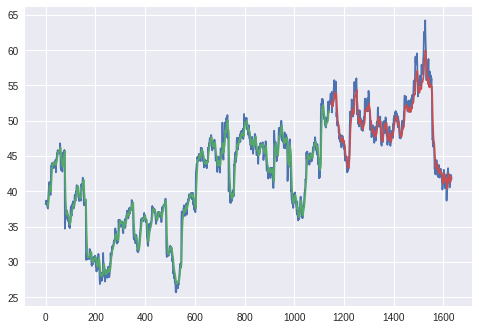

In [26]:
#lets plot the predictions on a graph and see how well it did
train_plot = np.empty_like(msft_close)
train_plot[:,:] = np.nan
train_plot[series:len(trainPredictions)+series, :] = trainPredictions

test_plot = np.empty_like(msft_close)
test_plot[:,:] = np.nan
test_plot[len(trainPredictions)+(series*2)+1:len(msft_close)-1, :] = testPredictions

#plot on graph
plt.plot(scaler.inverse_transform(msft_close))
plt.plot(train_plot)
plt.plot(test_plot)
plt.show()
